# Plotting validation periods

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
%load_ext autoreload
%autoreload 2
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, Interval,
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForPositiveMeasure,
    SocialDistancingForPositiveMeasureHousehold)
import botorch.utils.transforms as transforms
from lib.inference import (
    gen_initial_seeds, extract_seeds_from_summary,
    pdict_to_parr, parr_to_pdict, save_state, load_state, 
    gen_initial_seeds)
from lib.plot import Plotter
from lib.calibration_settings import (
    settings_optimized_town_params, 
    command_line_area_codes, 
    settings_lockdown_dates,
    settings_model_param_bounds,
    mob_setting_paths,
    calibration_states)
import matplotlib.pyplot as plt
%matplotlib inline

# converting days to hours
TO_HOURS = 24.0

In [3]:
c = 0
np.random.seed(c)
random_repeats = 24 # Set to at least 40 to obtain stable results
num_workers = multiprocessing.cpu_count()

In [4]:
def standard_testing(max_time, new_cases__):
    daily_increase = new_cases__.sum(axis=1)[1:] - new_cases__.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

#### Simulate for each town

In [5]:
def get_calibrated_params(country, area):
    state = load_state(calibration_states[country][area])
    theta = state['train_theta']
    best_observed_idx = state['best_observed_idx']
    norm_params = theta[best_observed_idx]
    sim_bounds = pdict_to_parr(settings_model_param_bounds, measures_optimized=False).T
    params = transforms.unnormalize(norm_params, sim_bounds)
    param_dict = parr_to_pdict(params, measures_optimized=False)
    return param_dict

def params_to_strg(d):
    l = [
        f"{d['betas']['education']:8.4f}",
        f"{d['betas']['social']:8.4f}",
        f"{d['betas']['bus_stop']:8.4f}",
        f"{d['betas']['office']:8.4f}",
        f"{d['betas']['supermarket']:8.4f}",
        f"{d['beta_household']:8.4f}",
    ]
    return ','.join(l)

headerstr = ' educat | social | bus_st | office | superm | househ '

In [6]:
sim = True

for country in ['GER', 'CH']:
    for area in mob_setting_paths[country].keys():

        mob_settings = mob_setting_paths[country][area][0]
        start_date = mob_setting_paths[country][area][1]
        end_date = mob_setting_paths[country][area][2]

        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours

        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data
        new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
        start_date_string=start_date, end_date_string=end_date)
        new_cases = np.ceil((mob.num_people_unscaled * new_cases_) 
                          / (mob.downsample * mob.region_population))

        # distributions
        distributions = CovidDistributions(country=country)

        # seeds
        initial_seeds = gen_initial_seeds(new_cases)

        # calibrated parameters
        calibrated_params = get_calibrated_params(country, area)
        
        print(country, area)
        print('Seeds: ', initial_seeds)
        print('Start: ', start_date, ' Cases : ', new_cases[0].sum())
        print('End:   ', end_date, ' Cases : ', new_cases[-1].sum())
        print(headerstr)
        print(params_to_strg(calibrated_params))
        print()

        # run
        measure_list =  [
            SocialDistancingForPositiveMeasure(
                t_window=Interval(0.0, max_time), p_stay_home=1.0),

            SocialDistancingForPositiveMeasureHousehold(
                t_window=Interval(0.0, max_time), p_isolate=1.0)
        ]
        measure_list = MeasureList(measure_list)

        # testing
        testing_params = standard_testing(max_time, new_cases)
        
        if sim:
            # run simulations
            summary = launch_parallel_simulations(
                mob_settings=mob_settings, 
                distributions=distributions, 
                random_repeats=random_repeats, 
                cpu_count=num_workers, 
                params=calibrated_params, 
                initial_seeds=initial_seeds, 
                testing_params=testing_params, 
                measure_list=measure_list, 
                max_time=max_time, 
                num_people=mob.num_people, 
                num_sites=mob.num_sites, 
                site_loc=mob.site_loc, 
                home_loc=mob.home_loc,
                dynamic_tracing=True,
                verbose=False)

            save_summary(summary, 'summary_calib_{}_{}.pk'.format(country, area))


GER TU
Seeds:  {'expo': 7, 'isym_posi': 2, 'iasy': 2}
Start:  2020-03-08  Cases :  2.0
End:    2020-03-27  Cases :  26.0
 educat | social | bus_st | office | superm | househ 
  0.1836,  0.5109,  0.7660,  0.5412,  0.9608,  0.2422

GER KL
Seeds:  {'expo': 4, 'isym_posi': 1, 'iasy': 1}
Start:  2020-03-08  Cases :  1.0
End:    2020-03-27  Cases :  6.0
 educat | social | bus_st | office | superm | househ 
  0.1536,  0.4939,  0.7125,  0.4621,  0.8269,  0.0651

GER RH
Seeds:  {'expo': 7, 'isym_posi': 2, 'iasy': 2}
Start:  2020-03-08  Cases :  2.0
End:    2020-03-27  Cases :  13.0
 educat | social | bus_st | office | superm | househ 
  0.1760,  1.2413,  0.1264,  0.0342,  1.3963,  0.1838

GER TR
Seeds:  {'expo': 4, 'isym_posi': 1, 'iasy': 1}
Start:  2020-03-10  Cases :  1.0
End:    2020-03-27  Cases :  30.0
 educat | social | bus_st | office | superm | househ 
  0.0928,  1.4261,  0.4109,  1.0123,  0.4455,  1.2376

CH VD
Seeds:  {'expo': 4, 'isym_posi': 1, 'iasy': 1}
Start:  2020-02-28  Cases : 

---

GER TU
GER KL
GER RH
GER TR
CH VD
CH LU
CH TI
CH JU


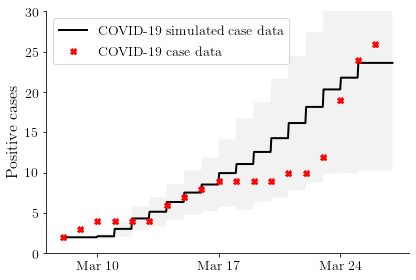

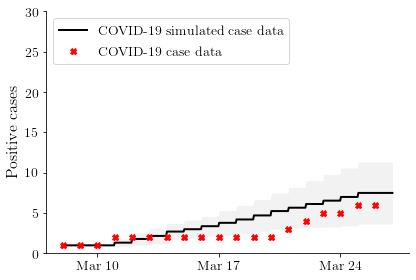

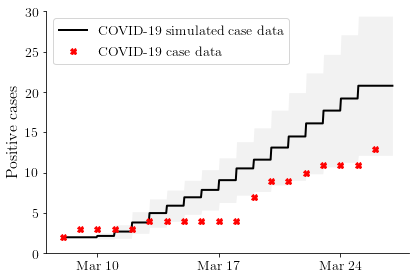

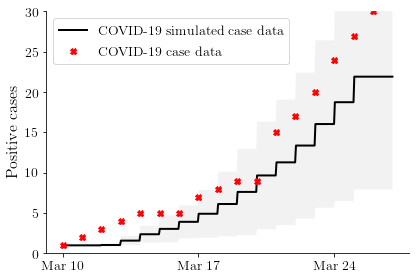

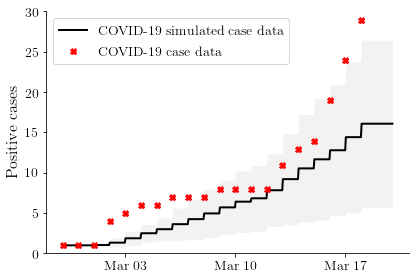

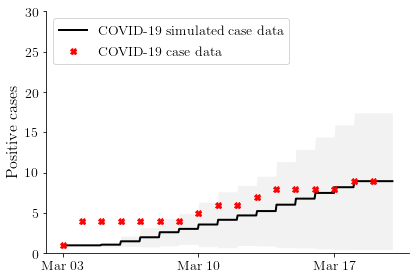

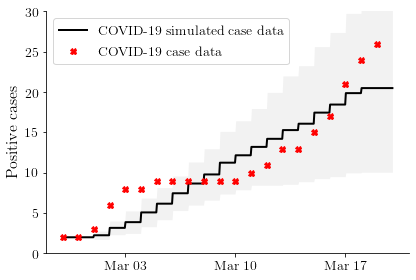

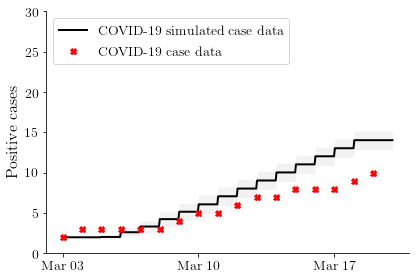

In [6]:
ymax = {
    'GER' : {
        'TU' : 30,
        'KL' : 30,
        'RH' : 30,
        'TR' : 30,
    },
    'CH' : {
        'VD' : 30,
        'LU' : 30,
        'TI' : 30,
        'JU' : 30,
    }
}

for country in ['GER', 'CH']:
    for area in mob_setting_paths[country].keys():

        print(country, area)

        mob_settings = mob_setting_paths[country][area][0]
        start_date = mob_setting_paths[country][area][1]
        end_date = mob_setting_paths[country][area][2]

        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours

        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data
        new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
        start_date_string=start_date, end_date_string=end_date)
        new_cases = np.ceil((mob.num_people_unscaled * new_cases_) 
                          / (mob.downsample * mob.region_population))


        summary = load_summary('summary_calib_{}_{}.pk'.format(country, area))
        plotter = Plotter()
        plotter.plot_positives_vs_target(
            summary, new_cases.sum(axis=1), 
            title='Calibration period', 
            filename='calibration_{}_{}_00'.format(country, area),
            figsize=(6, 4),
            start_date=start_date,
            errorevery=1, acc=1000, 
            ymax=ymax[country][area])
        
#         plotter.plot_age_group_positives_vs_target(summary, new_cases, 
#             ytitle=f'{country}-{area}',
#             filename='calibration_{}_{}_00'.format(country, area),
#             figsize=(16, 2.5),
#             start_date=start_date,
#             errorevery=1, acc=1000, 
#             ymax=ymax[country][area] / 4)
        
#         break
#     break
